# How to use our wav2vec 2.0 model to predict age and gender

In the following we present a hands-on to our model for age and gender prediction based on wav2vec 2.0. The model is publicly available for non-commercial usage from https://doi.org/10.5281/zenodo.7761387.

## Load model

We start by downloading and unpacking the model (we will use the six layer version). This will get us two files, a binary ONNX file containing the model weights and a YAML file with meta information about the model.

In [1]:
import os

import audeer


model_root = 'model'
cache_root = 'cache'


audeer.mkdir(cache_root)
def cache_path(file):
    return os.path.join(cache_root, file)


url = 'https://zenodo.org/record/7761387/files/w2v2-L-robust-6-age-gender.25c844af-1.1.1.zip'
dst_path = cache_path('model.zip')

if not os.path.exists(dst_path):
    audeer.download_url(url, dst_path, verbose=True)
    
if not os.path.exists(model_root):
    audeer.extract_archive(dst_path, model_root, verbose=True)

The package [audonnx](https://github.com/audeering/audonnx) helps us to load the model. Printing the model lists the input and output nodes. Since the model operates on the raw audio stream, we have a single input node called 'signal', which expects a mono signal with a sampling rate of 16000 Hz. We also see that the model has two output nodes: 'hidden_states', which gives us access to the pooled states of the last transformer layer, 'logits_age', which provides scores for age in a range of approximately 0...1 (== 100 years) and 'logits_gender', which expresses the confidence for being female, male or child.

In [2]:
import audonnx


model = audonnx.load(model_root)
model

Input:
  signal:
    shape: [1, -1]
    dtype: tensor(float)
    transform: None
Output:
  hidden_states:
    shape: [1, 1024]
    dtype: tensor(float)
    labels: [hidden_states-0, hidden_states-1, hidden_states-2, (...), hidden_states-1021,
      hidden_states-1022, hidden_states-1023]
  logits_age:
    shape: [1, 1]
    dtype: tensor(float)
    labels: [age]
  logits_gender:
    shape: [1, 3]
    dtype: tensor(float)
    labels: [female, male, child]

As a test, we call the model with some white noise. Note that we have to force the data type of the signal to 32-bit floating point precision. As result we get a dictionary with predictions for every output node.

In [3]:
import numpy as np


np.random.seed(0)

sampling_rate = 16000
signal = np.random.normal(
    size=sampling_rate,
).astype(np.float32)

model(signal, sampling_rate)

{'hidden_states': array([[ 0.02783544,  0.01402022,  0.03839185, ...,  0.00786646,
         -0.09332313,  0.0915948 ]], dtype=float32),
 'logits_age': array([[0.3961048]], dtype=float32),
 'logits_gender': array([[ 0.32810774, -0.56528044,  0.0317882 ]], dtype=float32)}

## Predict age and gender

A more advanced way of interfacing the model is offered by [audinterface](https://github.com/audeering/audinterface). Especially, the class [Feature](https://audeering.github.io/audinterface/api.html#feature) comes in handy, as it has the option to assign names to the output dimensions. To create the interface, we simply pass our callable model object as processing function. Since we are only interested in the scores for age and gender, we pass 'logits_age' and 'logits_gender' as an additional key word argument to `outputs`. To concatenate the outputs we set `concat` to `True`. And we enable automatic resampling in case the expected sampling rate of the model is not matched.

In [4]:
import audinterface


outputs = ['logits_age', 'logits_gender']
interface = audinterface.Feature(
    model.labels(outputs),
    process_func=model,
    process_func_args={
        'outputs': outputs,
        'concat': True,
    },
    sampling_rate=sampling_rate,
    resample=True,    
    verbose=True,
)

When we pass the signal to the interface, we get as result a table with proper column labels.

In [5]:
interface.process_signal(signal, sampling_rate)

,,age,female,male,child
start,end,,,,
0 days,0 days 00:00:01,0.396105,0.328108,-0.56528,0.031788


## Evaluate model on emodb

The Berlin Database of Emotional Speech ([Emo-DB](emodb.bilderbar.info)) is a well known speech databases with emotional utterances by different actors. It contains information on speaker age and gender, and expressions of emotional and non-emotional sentences in German. It will allow us to investigate if a) the model works on languages other than English b) it still works for affective speech. To get the database we use [audb](https://github.com/audeering/audb), a package to manage annotated media files. When we load the data, audb takes care of caching and converting the files to the desired format. Annotations are organized as tables in [audformat](https://github.com/audeering/audformat). In the following experiment we use columns with speaker information and emotional labels.

In [6]:
import audb
import audformat


db = audb.load(
    'emodb',
    version='1.3.0',
    format='wav',
    mixdown=True,
    sampling_rate=16000,
    full_path=False,    
    cache_root=cache_root,
    verbose=True,
)
age = db['files']['speaker'].get(map='age')
gender = db['files']['speaker'].get(map='gender')
emotion = db['emotion']['emotion'].get()

df = audformat.utils.concat([age, gender, emotion])
df

Get:   emodb v1.3.0
Cache: /media/jwagner/Data/Git/how-to/w2v2-age-gender-how-to/cache/emodb/1.3.0/fe182b91


,age,gender,emotion
file,,,
wav/03a01Fa.wav,31,male,happiness
wav/03a01Nc.wav,31,male,neutral
wav/03a01Wa.wav,31,male,anger
wav/03a02Fc.wav,31,male,happiness
wav/03a02Nc.wav,31,male,neutral
...,...,...,...
wav/16b10Lb.wav,31,female,boredom
wav/16b10Tb.wav,31,female,sadness
wav/16b10Td.wav,31,female,sadness


The interface we created earlier offers us a convenient way to run the model directly on the index of a table. Note that we cache the feature once extracted to avoid re-calculation.

In [7]:
pred = interface.process_index(
    df.index,
    root=db.root,
    cache_root=cache_root,
)
pred

,,,age,female,male,child
file,start,end,,,,
wav/03a01Fa.wav,0 days,0 days 00:00:01.898250,0.440541,1.464881,4.078879,-4.503115
wav/03a01Nc.wav,0 days,0 days 00:00:01.611250,0.262211,-1.394964,6.082706,-3.376553
wav/03a01Wa.wav,0 days,0 days 00:00:01.877812500,0.417828,0.194385,5.651813,-4.512995
wav/03a02Fc.wav,0 days,0 days 00:00:02.006250,0.311120,1.907180,1.848307,-3.264290
wav/03a02Nc.wav,0 days,0 days 00:00:01.439812500,0.287216,-1.302027,6.188240,-3.562538
...,...,...,...,...,...,...
wav/16b10Lb.wav,0 days,0 days 00:00:03.442687500,0.399840,6.157269,-1.738880,-4.453460
wav/16b10Tb.wav,0 days,0 days 00:00:03.500625,0.391874,5.663276,-0.568825,-4.939527
wav/16b10Td.wav,0 days,0 days 00:00:03.934187500,0.354147,5.773487,-1.090130,-4.626004


We multiply the normalized age predictions by 100.

In [8]:
pred_age = pred.age * 100

And determine the winning gender class.

In [9]:
pred_gender = pred.drop('age', axis=1).idxmax(axis=1)

We measure age performance by means of Mean Absolute Error (MAE), which we calculate with [audmetric](https://github.com/audeering/audmetric). In addition, we show a distribution plot that we create with [audplot](https://github.com/audeering/audplot).

8.348510439150802

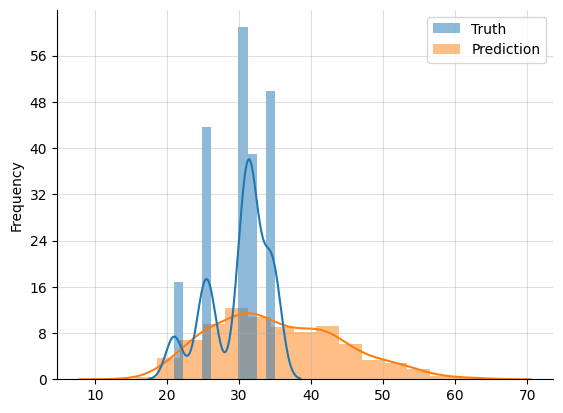

In [10]:
import audmetric
import audplot


audplot.distribution(age, pred_age)
audmetric.mean_absolute_error(    
    age,
    pred_age,
)

A mean average error of about 8 years is within the range we see for the datasets in the paper (tba). From the distribution we see that some of the samples are predicted too old.

To evaluate our gender predictions we calculate Unweighted Average Recall (UAR) and show a confusion matrix.

96.04496489781997

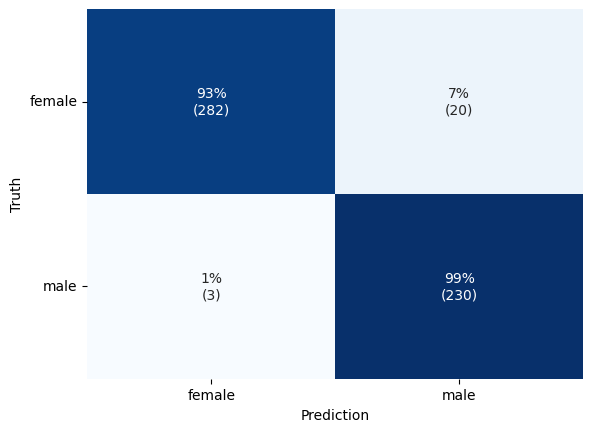

In [11]:
audplot.confusion_matrix(
    gender, 
    pred_gender,
    percentage=True,
    show_both=True,
)
audmetric.unweighted_average_recall(
    gender, 
    pred_gender,
) * 100

The confusion matrix tells us that almost all male samples are correctly labeled, but some of the female samples are mis-classified. A likely assumption is that the model has mainly issues with the affective speech. To prove this, we repeat the evaluation on the neutral samples.

5.940903651563427

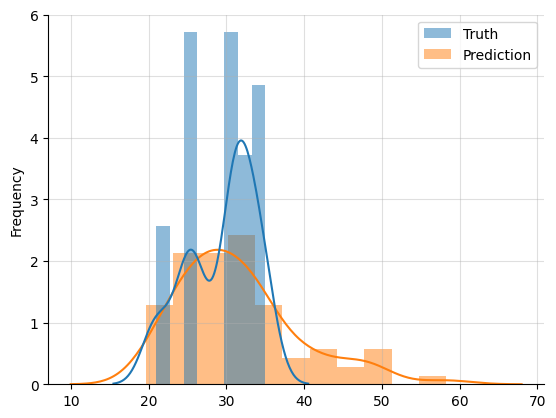

In [12]:
mask = (emotion == 'neutral').values

audplot.distribution(age[mask], pred_age[mask])
audmetric.mean_absolute_error(    
    age[mask],
    pred_age[mask],
)

And indeed, the error of the age prediction decreases by 2 years. And we get a perfect prediction of gender.

100.0

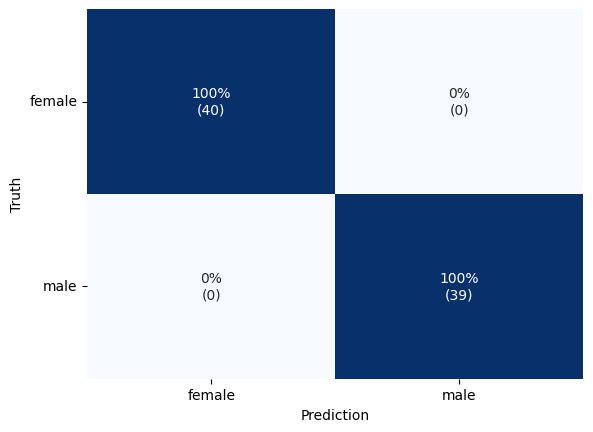

In [13]:
audplot.confusion_matrix(
    gender[mask], 
    pred_gender[mask],
    percentage=True,
    show_both=True,
)
audmetric.unweighted_average_recall(
    gender[mask], 
    pred_gender[mask],
) * 100